In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 大立光(3008)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 大立光(3008)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易大立光(3008)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('3008_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】

        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
       
        
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                
                Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅
                
                Buy = current_price + Buy_trade_fee#買入的成本
                Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本
                
                price_diff = Sold - Buy#最後賺到的錢
                
                
                
            elif(action == Actions.Sell.value):
                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                
                Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅
                
                Buy = last_trade_price + Buy_trade_fee#買入的成本
                Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本
                
                price_diff = Sold - Buy#最後賺到的錢
        
        step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                
                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                    
                Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅
                
                Buy = current_price + Buy_trade_fee#買入的成本
                Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本
                
                price_diff = Sold - Buy#最後賺到的錢
                long_profit_percentage = (Sold - Buy)/Buy
                self._total_profit += long_profit_percentage
                
            elif(action == Actions.Sell.value):

                current_price = self.close[self._current_tick]*1000#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】
                
                Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                if Buy_trade_fee<20:
                    Buy_trade_fee=20
                Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                if Sold_trade_fee<20:
                    Sold_trade_fee=20
                Transfer_tax = last_trade_price * 0.003 #證交稅
                
                Buy = last_trade_price + Buy_trade_fee#買入的成本
                Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本
                
                price_diff = Sold - Buy#最後賺到的錢
                short_profit_percentage = (Sold - Buy)/Buy 
                self._total_profit += short_profit_percentage  
                       
                
        step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
if isinstance('3008.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('3008.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI
#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
0,2002-04-05,103.632324,103.632324,103.632324,103.632324,67.701004,0.0,3008.TW,101.329536,121.284645,...,0.000000,0.000000,28.351649,15.737990,25.210904,-9.183556,-9.270268,136.775099,112.152976,87.530853
1,2002-04-08,99.796707,105.553665,99.796707,105.165154,68.702385,971809.0,3008.TW,99.796707,120.903198,...,0.388512,0.000000,27.272716,18.970343,23.130717,-8.990700,-9.214355,124.825565,109.676424,94.527282
2,2002-04-09,104.783714,104.783714,102.862373,102.862373,67.198006,528893.0,3008.TW,99.796707,115.527679,...,0.000000,0.000000,20.573908,19.142926,21.801453,-8.920842,-9.155652,122.906133,110.328761,97.751390
3,2002-04-10,102.862373,105.553665,102.480934,105.553665,68.956192,455941.0,3008.TW,99.796707,114.764801,...,0.000000,0.381439,28.769552,25.582461,23.061789,-8.549757,-9.034473,121.786104,110.808743,99.831383
4,2002-04-11,107.467941,109.389282,106.705055,109.007835,71.212738,956175.0,3008.TW,99.796707,113.224899,...,0.381447,0.762886,31.581485,39.920122,28.681233,-7.886042,-8.804787,121.472139,111.135088,100.798038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,2023-02-23,2215.000000,2250.000000,2215.000000,2225.000000,2225.000000,285036.0,3008.TW,2165.000000,2270.000000,...,25.000000,0.000000,51.250000,45.739478,42.111814,16.128969,16.553873,2292.310672,2205.750000,2119.189328
5157,2023-02-24,2245.000000,2255.000000,2205.000000,2205.000000,2205.000000,405228.0,3008.TW,2165.000000,2270.000000,...,10.000000,0.000000,46.250000,43.191398,42.471675,14.293006,16.101699,2274.737999,2212.250000,2149.762001
5158,2023-03-01,2155.000000,2185.000000,2155.000000,2165.000000,2165.000000,556733.0,3008.TW,2155.000000,2270.000000,...,20.000000,0.000000,44.578313,31.692816,38.878722,9.500808,14.781521,2274.737999,2212.250000,2149.762001
5159,2023-03-02,2165.000000,2215.000000,2135.000000,2210.000000,2210.000000,482042.0,3008.TW,2135.000000,2270.000000,...,5.000000,30.000000,44.578313,39.647062,39.134835,9.227709,13.670759,2264.572861,2216.500000,2168.427139


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4393

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5126

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,UpLine,DownLine,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track
4393,2020-01-02,5055.0,5090.0,5015.0,5030.0,4531.392090,398147.0,3008.TW,4860.0,5130.0,...,35.0,15.0,65.354331,46.801609,44.691211,112.624010,114.305162,5144.945513,4889.75,4634.554487
4394,2020-01-03,5105.0,5155.0,4875.0,4880.0,4396.261230,892399.0,3008.TW,4860.0,5155.0,...,50.0,5.0,36.206897,33.460960,40.947794,99.557963,111.355722,5139.895919,4898.25,4656.604081
4395,2020-01-06,4780.0,4865.0,4680.0,4695.0,4229.599121,1276386.0,3008.TW,4680.0,5155.0,...,85.0,15.0,27.450980,23.359938,35.085175,73.428633,103.770304,5139.292442,4898.50,4657.707558
4396,2020-01-07,4740.0,4785.0,4640.0,4740.0,4270.138672,846521.0,3008.TW,4640.0,5155.0,...,45.0,100.0,29.746835,22.045784,30.738712,55.709886,94.158220,5142.912963,4894.50,4646.087037
4397,2020-01-08,4700.0,4820.0,4670.0,4785.0,4310.678223,510126.0,3008.TW,4640.0,5155.0,...,35.0,30.0,34.782609,24.082303,28.519909,44.782550,84.283086,5133.130865,4900.00,4666.869135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,2022-12-26,2160.0,2160.0,2110.0,2120.0,2120.000000,146374.0,3008.TW,2110.0,2280.0,...,0.0,10.0,32.394366,16.278754,25.960075,6.368110,32.395522,2339.215224,2230.50,2121.784776
5123,2022-12-27,2130.0,2165.0,2130.0,2165.0,2165.000000,190969.0,3008.TW,2110.0,2280.0,...,0.0,0.0,46.376812,21.636816,24.518989,3.887431,26.693904,2335.951174,2225.25,2114.548826
5124,2022-12-28,2145.0,2150.0,2105.0,2110.0,2110.000000,275648.0,3008.TW,2105.0,2280.0,...,5.0,5.0,38.461538,15.376925,21.471634,-2.487886,20.857546,2332.601887,2216.00,2099.398113
5125,2022-12-29,2075.0,2075.0,2040.0,2050.0,2050.000000,509610.0,3008.TW,2040.0,2280.0,...,0.0,10.0,34.090909,11.640172,18.194480,-12.240766,14.237883,2336.045447,2204.00,2071.954553


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    signal_features = df.loc[:, ['Up_Track', 'Mid_Track','Down_Track']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._signal_features

    
open, close, high, low, volume, signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [24]:
policy_kwargs = dict(net_arch=[256, 'lstm', dict(vf=[128,128,128], pi=[128,128,128])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=0.00000005)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=1000000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 14       |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 2.2e+10  |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 305       |
| nupdates           | 100       |
| policy_entropy     | 0.69      |
| total_timesteps    | 500       |
| value_loss         | 1.06e+10  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 365       |
| nupdates           | 200       |
| policy_entropy     | 0.69      |
| total_timesteps    | 1000      |
| value_loss         | 8.19e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 391      |
| nupdates           | 300     

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 433       |
| nupdates           | 3000      |
| policy_entropy     | 0.688     |
| total_timesteps    | 15000     |
| value_loss         | 2.31e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 429       |
| nupdates           | 3100      |
| policy_entropy     | 0.693     |
| total_timesteps    | 15500     |
| value_loss         | 1.07e+10  |
----------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 426      |
| nupdates           | 3200     |
| policy_entropy     | 0.688    |
| total_timesteps    | 16000    |
| value_loss         | 1.49e+09 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 423      |
| nupdates           | 3300     |
| policy_entropy     | 0.692    

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 381       |
| nupdates           | 6000      |
| policy_entropy     | 0.693     |
| total_timesteps    | 30000     |
| value_loss         | 2.92e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 380      |
| nupdates           | 6100     |
| policy_entropy     | 0.69     |
| total_timesteps    | 30500    |
| value_loss         | 4.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 380      |
| nupdates           | 6200     |
| policy_entropy     | 0.692    |
| total_timesteps    | 31000    |
| value_loss         | 1.14e+09 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 379       |
| nupdates           | 6300      |
| policy_entropy     | 0.69      |
|

---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 340      |
| nupdates           | 9000     |
| policy_entropy     | 0.692    |
| total_timesteps    | 45000    |
| value_loss         | 9.41e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 338      |
| nupdates           | 9100     |
| policy_entropy     | 0.691    |
| total_timesteps    | 45500    |
| value_loss         | 1.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 337      |
| nupdates           | 9200     |
| policy_entropy     | 0.692    |
| total_timesteps    | 46000    |
| value_loss         | 9.78e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 335      |
| nupdates           | 9300     |
| policy_entropy     | 0.691    |
| total_timest

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 295      |
| nupdates           | 12000    |
| policy_entropy     | 0.692    |
| total_timesteps    | 60000    |
| value_loss         | 7.1e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 293      |
| nupdates           | 12100    |
| policy_entropy     | 0.693    |
| total_timesteps    | 60500    |
| value_loss         | 7.56e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 292      |
| nupdates           | 12200    |
| policy_entropy     | 0.693    |
| total_timesteps    | 61000    |
| value_loss         | 7.16e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 290       |
| nupdates           | 12300     |
| policy_entropy     | 0.692     |
| total_t

---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 253      |
| nupdates           | 15000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 75000    |
| value_loss         | 4.59e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 252      |
| nupdates           | 15100    |
| policy_entropy     | 0.688    |
| total_timesteps    | 75500    |
| value_loss         | 2.9e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 250       |
| nupdates           | 15200     |
| policy_entropy     | 0.693     |
| total_timesteps    | 76000     |
| value_loss         | 1.02e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 249      |
| nupdates           | 15300    |
| policy_entropy     | 0.693    |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 217      |
| nupdates           | 18000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 90000    |
| value_loss         | 1.11e+09 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 216       |
| nupdates           | 18100     |
| policy_entropy     | 0.691     |
| total_timesteps    | 90500     |
| value_loss         | 1.25e+10  |
----------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 215       |
| nupdates           | 18200     |
| policy_entropy     | 0.677     |
| total_timesteps    | 91000     |
| value_loss         | 1.24e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 214      |
| nupdates           | 18300    |
| policy_entropy     | 0.693    

---------------------------------
| explained_variance | 0        |
| fps                | 189      |
| nupdates           | 21000    |
| policy_entropy     | 0.693    |
| total_timesteps    | 105000   |
| value_loss         | 7.8e+09  |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 189      |
| nupdates           | 21100    |
| policy_entropy     | 0.693    |
| total_timesteps    | 105500   |
| value_loss         | 8.64e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 189       |
| nupdates           | 21200     |
| policy_entropy     | 0.692     |
| total_timesteps    | 106000    |
| value_loss         | 1.53e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 188      |
| nupdates           | 21300    |
| policy_entropy     | 0.689    |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 178      |
| nupdates           | 24000    |
| policy_entropy     | 0.686    |
| total_timesteps    | 120000   |
| value_loss         | 3.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 178      |
| nupdates           | 24100    |
| policy_entropy     | 0.685    |
| total_timesteps    | 120500   |
| value_loss         | 6.11e+10 |
---------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 177      |
| nupdates           | 24200    |
| policy_entropy     | 0.682    |
| total_timesteps    | 121000   |
| value_loss         | 2.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 177      |
| nupdates           | 24300    |
| policy_entropy     | 0.692    |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 171      |
| nupdates           | 27000    |
| policy_entropy     | 0.689    |
| total_timesteps    | 135000   |
| value_loss         | 5.17e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 171      |
| nupdates           | 27100    |
| policy_entropy     | 0.686    |
| total_timesteps    | 135500   |
| value_loss         | 3.63e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 171      |
| nupdates           | 27200    |
| policy_entropy     | 0.69     |
| total_timesteps    | 136000   |
| value_loss         | 4.59e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 171      |
| nupdates           | 27300    |
| policy_entropy     | 0.674    |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 167      |
| nupdates           | 30000    |
| policy_entropy     | 0.687    |
| total_timesteps    | 150000   |
| value_loss         | 4.2e+09  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 167       |
| nupdates           | 30100     |
| policy_entropy     | 0.689     |
| total_timesteps    | 150500    |
| value_loss         | 1.15e+10  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 167       |
| nupdates           | 30200     |
| policy_entropy     | 0.689     |
| total_timesteps    | 151000    |
| value_loss         | 4.94e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 167      |
| nupdates           | 30300    |
| policy_entropy     | 0.677    

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 164       |
| nupdates           | 33000     |
| policy_entropy     | 0.687     |
| total_timesteps    | 165000    |
| value_loss         | 3.61e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 163      |
| nupdates           | 33100    |
| policy_entropy     | 0.684    |
| total_timesteps    | 165500   |
| value_loss         | 8.26e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 163      |
| nupdates           | 33200    |
| policy_entropy     | 0.672    |
| total_timesteps    | 166000   |
| value_loss         | 3e+10    |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 163      |
| nupdates           | 33300    |
| policy_entropy     | 0.682    |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 161       |
| nupdates           | 36000     |
| policy_entropy     | 0.681     |
| total_timesteps    | 180000    |
| value_loss         | 5.26e+09  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 161      |
| nupdates           | 36100    |
| policy_entropy     | 0.684    |
| total_timesteps    | 180500   |
| value_loss         | 1.33e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 161      |
| nupdates           | 36200    |
| policy_entropy     | 0.679    |
| total_timesteps    | 181000   |
| value_loss         | 2.27e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 161       |
| nupdates           | 36300     |
| policy_entropy     | 0.679     |
|

----------------------------------
| explained_variance | -6.32e-06 |
| fps                | 159       |
| nupdates           | 39000     |
| policy_entropy     | 0.669     |
| total_timesteps    | 195000    |
| value_loss         | 3.55e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 159      |
| nupdates           | 39100    |
| policy_entropy     | 0.682    |
| total_timesteps    | 195500   |
| value_loss         | 6.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 159      |
| nupdates           | 39200    |
| policy_entropy     | 0.679    |
| total_timesteps    | 196000   |
| value_loss         | 8.11e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 158      |
| nupdates           | 39300    |
| policy_entropy     | 0.673    |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 157      |
| nupdates           | 42000    |
| policy_entropy     | 0.669    |
| total_timesteps    | 210000   |
| value_loss         | 3.79e+10 |
---------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 157      |
| nupdates           | 42100    |
| policy_entropy     | 0.679    |
| total_timesteps    | 210500   |
| value_loss         | 2.09e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 157       |
| nupdates           | 42200     |
| policy_entropy     | 0.679     |
| total_timesteps    | 211000    |
| value_loss         | 6.43e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 157       |
| nupdates           | 42300     |
| policy_entropy     | 0.67      |
|

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 155      |
| nupdates           | 45000    |
| policy_entropy     | 0.676    |
| total_timesteps    | 225000   |
| value_loss         | 1.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 155      |
| nupdates           | 45100    |
| policy_entropy     | 0.674    |
| total_timesteps    | 225500   |
| value_loss         | 2.6e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 155      |
| nupdates           | 45200    |
| policy_entropy     | 0.676    |
| total_timesteps    | 226000   |
| value_loss         | 2.9e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 155      |
| nupdates           | 45300    |
| policy_entropy     | 0.671    |
| total_timest

---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 154      |
| nupdates           | 48000    |
| policy_entropy     | 0.635    |
| total_timesteps    | 240000   |
| value_loss         | 4.95e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 154      |
| nupdates           | 48100    |
| policy_entropy     | 0.667    |
| total_timesteps    | 240500   |
| value_loss         | 5.02e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 154       |
| nupdates           | 48200     |
| policy_entropy     | 0.668     |
| total_timesteps    | 241000    |
| value_loss         | 2.62e+10  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 154      |
| nupdates           | 48300    |
| policy_entropy     | 0.662    |
| tota

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 153      |
| nupdates           | 51000    |
| policy_entropy     | 0.657    |
| total_timesteps    | 255000   |
| value_loss         | 6.44e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 153      |
| nupdates           | 51100    |
| policy_entropy     | 0.656    |
| total_timesteps    | 255500   |
| value_loss         | 6.47e+09 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 153      |
| nupdates           | 51200    |
| policy_entropy     | 0.658    |
| total_timesteps    | 256000   |
| value_loss         | 2.2e+09  |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 153       |
| nupdates           | 51300     |
| policy_entropy     | 0.666     |
| total_t

---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 152      |
| nupdates           | 54000    |
| policy_entropy     | 0.645    |
| total_timesteps    | 270000   |
| value_loss         | 1.14e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 152       |
| nupdates           | 54100     |
| policy_entropy     | 0.656     |
| total_timesteps    | 270500    |
| value_loss         | 5.25e+09  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 152       |
| nupdates           | 54200     |
| policy_entropy     | 0.658     |
| total_timesteps    | 271000    |
| value_loss         | 9.6e+09   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 152       |
| nupdates           | 54300     |
| policy_entropy     | 0.657

---------------------------------
| explained_variance | 0        |
| fps                | 151      |
| nupdates           | 57000    |
| policy_entropy     | 0.653    |
| total_timesteps    | 285000   |
| value_loss         | 1.56e+10 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 151      |
| nupdates           | 57100    |
| policy_entropy     | 0.632    |
| total_timesteps    | 285500   |
| value_loss         | 1.21e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 151       |
| nupdates           | 57200     |
| policy_entropy     | 0.654     |
| total_timesteps    | 286000    |
| value_loss         | 1.58e+09  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 151       |
| nupdates           | 57300     |
| policy_entropy     | 0.646     |
|

----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 150       |
| nupdates           | 60000     |
| policy_entropy     | 0.647     |
| total_timesteps    | 300000    |
| value_loss         | 1.95e+09  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 150      |
| nupdates           | 60100    |
| policy_entropy     | 0.627    |
| total_timesteps    | 300500   |
| value_loss         | 4.84e+09 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 150      |
| nupdates           | 60200    |
| policy_entropy     | 0.658    |
| total_timesteps    | 301000   |
| value_loss         | 4.57e+10 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 150       |
| nupdates           | 60300     |
| policy_entropy     | 0.648     |
|

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 150      |
| nupdates           | 63000    |
| policy_entropy     | 0.635    |
| total_timesteps    | 315000   |
| value_loss         | 9.8e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 150      |
| nupdates           | 63100    |
| policy_entropy     | 0.638    |
| total_timesteps    | 315500   |
| value_loss         | 1.01e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 150       |
| nupdates           | 63200     |
| policy_entropy     | 0.636     |
| total_timesteps    | 316000    |
| value_loss         | 4.45e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 150       |
| nupdates           | 63300     |
| policy_entropy     | 0.639     |
|

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 149      |
| nupdates           | 66000    |
| policy_entropy     | 0.636    |
| total_timesteps    | 330000   |
| value_loss         | 5.57e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 149       |
| nupdates           | 66100     |
| policy_entropy     | 0.637     |
| total_timesteps    | 330500    |
| value_loss         | 7.1e+09   |
----------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 149      |
| nupdates           | 66200    |
| policy_entropy     | 0.629    |
| total_timesteps    | 331000   |
| value_loss         | 7.5e+08  |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 149      |
| nupdates           | 66300    |
| policy_entropy     | 0.632    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 69000    |
| policy_entropy     | 0.625    |
| total_timesteps    | 345000   |
| value_loss         | 3.11e+10 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 149       |
| nupdates           | 69100     |
| policy_entropy     | 0.626     |
| total_timesteps    | 345500    |
| value_loss         | 6.92e+09  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 149       |
| nupdates           | 69200     |
| policy_entropy     | 0.607     |
| total_timesteps    | 346000    |
| value_loss         | 1.05e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 149      |
| nupdates           | 69300    |
| policy_entropy     | 0.632    

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 148       |
| nupdates           | 72000     |
| policy_entropy     | 0.631     |
| total_timesteps    | 360000    |
| value_loss         | 2.91e+08  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 148      |
| nupdates           | 72100    |
| policy_entropy     | 0.621    |
| total_timesteps    | 360500   |
| value_loss         | 1.62e+10 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 148       |
| nupdates           | 72200     |
| policy_entropy     | 0.617     |
| total_timesteps    | 361000    |
| value_loss         | 1.13e+09  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 148       |
| nupdates           | 72300     |
| policy_entropy     | 0.621

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 148       |
| nupdates           | 75000     |
| policy_entropy     | 0.618     |
| total_timesteps    | 375000    |
| value_loss         | 3.52e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 148      |
| nupdates           | 75100    |
| policy_entropy     | 0.617    |
| total_timesteps    | 375500   |
| value_loss         | 2.23e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 148       |
| nupdates           | 75200     |
| policy_entropy     | 0.613     |
| total_timesteps    | 376000    |
| value_loss         | 1.83e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 148       |
| nupdates           | 75300     |
| policy_entropy     | 0.614

---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 78000    |
| policy_entropy     | 0.606    |
| total_timesteps    | 390000   |
| value_loss         | 1.25e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 147       |
| nupdates           | 78100     |
| policy_entropy     | 0.603     |
| total_timesteps    | 390500    |
| value_loss         | 3.25e+09  |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 147      |
| nupdates           | 78200    |
| policy_entropy     | 0.606    |
| total_timesteps    | 391000   |
| value_loss         | 2.07e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 147      |
| nupdates           | 78300    |
| policy_entropy     | 0.608    |
| tota

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 147       |
| nupdates           | 81000     |
| policy_entropy     | 0.606     |
| total_timesteps    | 405000    |
| value_loss         | 3.9e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 81100    |
| policy_entropy     | 0.599    |
| total_timesteps    | 405500   |
| value_loss         | 4.52e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 147      |
| nupdates           | 81200    |
| policy_entropy     | 0.602    |
| total_timesteps    | 406000   |
| value_loss         | 1.62e+10 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 147      |
| nupdates           | 81300    |
| policy_entropy     | 0.598    |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 146       |
| nupdates           | 84000     |
| policy_entropy     | 0.595     |
| total_timesteps    | 420000    |
| value_loss         | 2.82e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 84100     |
| policy_entropy     | 0.589     |
| total_timesteps    | 420500    |
| value_loss         | 1.93e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 146      |
| nupdates           | 84200    |
| policy_entropy     | 0.591    |
| total_timesteps    | 421000   |
| value_loss         | 1.74e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 84300    |
| policy_entropy     | 0.59     

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 146       |
| nupdates           | 87000     |
| policy_entropy     | 0.589     |
| total_timesteps    | 435000    |
| value_loss         | 7.61e+08  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 146       |
| nupdates           | 87100     |
| policy_entropy     | 0.581     |
| total_timesteps    | 435500    |
| value_loss         | 2.94e+09  |
----------------------------------
----------------------------------
| explained_variance | -9.18e-06 |
| fps                | 146       |
| nupdates           | 87200     |
| policy_entropy     | 0.611     |
| total_timesteps    | 436000    |
| value_loss         | 1.87e+10  |
----------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 146       |
| nupdates           | 87300     |
| policy_entropy    

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 146      |
| nupdates           | 90000    |
| policy_entropy     | 0.612    |
| total_timesteps    | 450000   |
| value_loss         | 4.63e+10 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 146       |
| nupdates           | 90100     |
| policy_entropy     | 0.585     |
| total_timesteps    | 450500    |
| value_loss         | 2.1e+08   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 90200    |
| policy_entropy     | 0.579    |
| total_timesteps    | 451000   |
| value_loss         | 4.2e+09  |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 146      |
| nupdates           | 90300    |
| policy_entropy     | 0.576    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 93000     |
| policy_entropy     | 0.571     |
| total_timesteps    | 465000    |
| value_loss         | 5.69e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 93100    |
| policy_entropy     | 0.57     |
| total_timesteps    | 465500   |
| value_loss         | 4.25e+10 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 145       |
| nupdates           | 93200     |
| policy_entropy     | 0.561     |
| total_timesteps    | 466000    |
| value_loss         | 2.99e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 93300     |
| policy_entropy     | 0.571

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 145       |
| nupdates           | 96000     |
| policy_entropy     | 0.562     |
| total_timesteps    | 480000    |
| value_loss         | 3.12e+09  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 96100    |
| policy_entropy     | 0.563    |
| total_timesteps    | 480500   |
| value_loss         | 8.52e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 96200     |
| policy_entropy     | 0.547     |
| total_timesteps    | 481000    |
| value_loss         | 7.36e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.11e-05 |
| fps                | 145       |
| nupdates           | 96300     |
| policy_entropy     | 0.551

---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 145      |
| nupdates           | 99000    |
| policy_entropy     | 0.54     |
| total_timesteps    | 495000   |
| value_loss         | 2.47e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 99100     |
| policy_entropy     | 0.552     |
| total_timesteps    | 495500    |
| value_loss         | 2.58e+11  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 145      |
| nupdates           | 99200    |
| policy_entropy     | 0.553    |
| total_timesteps    | 496000   |
| value_loss         | 7.59e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 145       |
| nupdates           | 99300     |
| policy_entropy     | 0.556     |
|

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 102000   |
| policy_entropy     | 0.545    |
| total_timesteps    | 510000   |
| value_loss         | 2.2e+09  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 102100   |
| policy_entropy     | 0.546    |
| total_timesteps    | 510500   |
| value_loss         | 1.88e+09 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 144      |
| nupdates           | 102200   |
| policy_entropy     | 0.543    |
| total_timesteps    | 511000   |
| value_loss         | 7.8e+08  |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 144       |
| nupdates           | 102300    |
| policy_entropy     | 0.529     |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 144      |
| nupdates           | 105000   |
| policy_entropy     | 0.537    |
| total_timesteps    | 525000   |
| value_loss         | 5.47e+09 |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 144      |
| nupdates           | 105100   |
| policy_entropy     | 0.537    |
| total_timesteps    | 525500   |
| value_loss         | 5.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 105200   |
| policy_entropy     | 0.537    |
| total_timesteps    | 526000   |
| value_loss         | 1.46e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 144       |
| nupdates           | 105300    |
| policy_entropy     | 0.533     |
| total_t

----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 144       |
| nupdates           | 108000    |
| policy_entropy     | 0.527     |
| total_timesteps    | 540000    |
| value_loss         | 1.93e+08  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 144      |
| nupdates           | 108100   |
| policy_entropy     | 0.531    |
| total_timesteps    | 540500   |
| value_loss         | 5.6e+09  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 108200    |
| policy_entropy     | 0.53      |
| total_timesteps    | 541000    |
| value_loss         | 1.1e+11   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 108300   |
| policy_entropy     | 0.53     

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 144       |
| nupdates           | 111000    |
| policy_entropy     | 0.526     |
| total_timesteps    | 555000    |
| value_loss         | 1.45e+09  |
----------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 144      |
| nupdates           | 111100   |
| policy_entropy     | 0.525    |
| total_timesteps    | 555500   |
| value_loss         | 1.32e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 111200    |
| policy_entropy     | 0.524     |
| total_timesteps    | 556000    |
| value_loss         | 1.38e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 111300    |
| policy_entropy     | 0.524

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 114000    |
| policy_entropy     | 0.518     |
| total_timesteps    | 570000    |
| value_loss         | 1.19e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 114100   |
| policy_entropy     | 0.518    |
| total_timesteps    | 570500   |
| value_loss         | 4.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 144      |
| nupdates           | 114200   |
| policy_entropy     | 0.524    |
| total_timesteps    | 571000   |
| value_loss         | 1.62e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 144       |
| nupdates           | 114300    |
| policy_entropy     | 0.524     |
|

----------------------------------
| explained_variance | -1.63e-05 |
| fps                | 144       |
| nupdates           | 117000    |
| policy_entropy     | 0.544     |
| total_timesteps    | 585000    |
| value_loss         | 4.9e+09   |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 144       |
| nupdates           | 117100    |
| policy_entropy     | 0.481     |
| total_timesteps    | 585500    |
| value_loss         | 2.69e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 117200    |
| policy_entropy     | 0.513     |
| total_timesteps    | 586000    |
| value_loss         | 2.32e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 117300   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 120000    |
| policy_entropy     | 0.505     |
| total_timesteps    | 600000    |
| value_loss         | 6.05e+09  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 143      |
| nupdates           | 120100   |
| policy_entropy     | 0.504    |
| total_timesteps    | 600500   |
| value_loss         | 1.61e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 120200   |
| policy_entropy     | 0.504    |
| total_timesteps    | 601000   |
| value_loss         | 7.7e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 120300   |
| policy_entropy     | 0.504    |
| tota

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 143       |
| nupdates           | 123000    |
| policy_entropy     | 0.482     |
| total_timesteps    | 615000    |
| value_loss         | 1.03e+09  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 143       |
| nupdates           | 123100    |
| policy_entropy     | 0.5       |
| total_timesteps    | 615500    |
| value_loss         | 4.29e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 143       |
| nupdates           | 123200    |
| policy_entropy     | 0.502     |
| total_timesteps    | 616000    |
| value_loss         | 6.43e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 143      |
| nupdates           | 123300   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 143      |
| nupdates           | 126000   |
| policy_entropy     | 0.482    |
| total_timesteps    | 630000   |
| value_loss         | 1.59e+09 |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 143       |
| nupdates           | 126100    |
| policy_entropy     | 0.479     |
| total_timesteps    | 630500    |
| value_loss         | 2.75e+09  |
----------------------------------
---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 143      |
| nupdates           | 126200   |
| policy_entropy     | 0.483    |
| total_timesteps    | 631000   |
| value_loss         | 1.18e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 143       |
| nupdates           | 126300    |
| policy_entropy     | 0.492     |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 129000   |
| policy_entropy     | 0.488    |
| total_timesteps    | 645000   |
| value_loss         | 2.36e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 129100   |
| policy_entropy     | 0.484    |
| total_timesteps    | 645500   |
| value_loss         | 1.92e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 143       |
| nupdates           | 129200    |
| policy_entropy     | 0.484     |
| total_timesteps    | 646000    |
| value_loss         | 4.61e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 129300   |
| policy_entropy     | 0.487    |
| tota

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 143      |
| nupdates           | 132000   |
| policy_entropy     | 0.481    |
| total_timesteps    | 660000   |
| value_loss         | 1.28e+10 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 132100   |
| policy_entropy     | 0.469    |
| total_timesteps    | 660500   |
| value_loss         | 3.76e+08 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 143       |
| nupdates           | 132200    |
| policy_entropy     | 0.481     |
| total_timesteps    | 661000    |
| value_loss         | 1.37e+09  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 143      |
| nupdates           | 132300   |
| policy_entropy     | 0.483    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 135000   |
| policy_entropy     | 0.48     |
| total_timesteps    | 675000   |
| value_loss         | 3.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 143      |
| nupdates           | 135100   |
| policy_entropy     | 0.47     |
| total_timesteps    | 675500   |
| value_loss         | 1.12e+09 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 143       |
| nupdates           | 135200    |
| policy_entropy     | 0.458     |
| total_timesteps    | 676000    |
| value_loss         | 2.16e+09  |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 143      |
| nupdates           | 135300   |
| policy_entropy     | 0.485    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 138000   |
| policy_entropy     | 0.473    |
| total_timesteps    | 690000   |
| value_loss         | 1.99e+10 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 142       |
| nupdates           | 138100    |
| policy_entropy     | 0.473     |
| total_timesteps    | 690500    |
| value_loss         | 6.43e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 138200    |
| policy_entropy     | 0.472     |
| total_timesteps    | 691000    |
| value_loss         | 1.54e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 138300   |
| policy_entropy     | 0.478    

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 141000   |
| policy_entropy     | 0.469    |
| total_timesteps    | 705000   |
| value_loss         | 6.16e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 141100   |
| policy_entropy     | 0.469    |
| total_timesteps    | 705500   |
| value_loss         | 3.77e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 142       |
| nupdates           | 141200    |
| policy_entropy     | 0.458     |
| total_timesteps    | 706000    |
| value_loss         | 5.56e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 141300   |
| policy_entropy     | 0.468    |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 144000   |
| policy_entropy     | 0.468    |
| total_timesteps    | 720000   |
| value_loss         | 8.79e+09 |
---------------------------------
---------------------------------
| explained_variance | 5.42e-06 |
| fps                | 142      |
| nupdates           | 144100   |
| policy_entropy     | 0.475    |
| total_timesteps    | 720500   |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 144200   |
| policy_entropy     | 0.465    |
| total_timesteps    | 721000   |
| value_loss         | 6.81e+09 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 142       |
| nupdates           | 144300    |
| policy_entropy     | 0.45      |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 147000   |
| policy_entropy     | 0.459    |
| total_timesteps    | 735000   |
| value_loss         | 4.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 147100   |
| policy_entropy     | 0.457    |
| total_timesteps    | 735500   |
| value_loss         | 3.83e+10 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 147200    |
| policy_entropy     | 0.457     |
| total_timesteps    | 736000    |
| value_loss         | 1.31e+09  |
----------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 142      |
| nupdates           | 147300   |
| policy_entropy     | 0.443    |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 150000    |
| policy_entropy     | 0.453     |
| total_timesteps    | 750000    |
| value_loss         | 1.59e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 150100   |
| policy_entropy     | 0.452    |
| total_timesteps    | 750500   |
| value_loss         | 2.12e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 150200   |
| policy_entropy     | 0.455    |
| total_timesteps    | 751000   |
| value_loss         | 5.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 150300   |
| policy_entropy     | 0.451    |
| tota

----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 142       |
| nupdates           | 153000    |
| policy_entropy     | 0.455     |
| total_timesteps    | 765000    |
| value_loss         | 2.07e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 153100   |
| policy_entropy     | 0.447    |
| total_timesteps    | 765500   |
| value_loss         | 1.37e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 142      |
| nupdates           | 153200   |
| policy_entropy     | 0.469    |
| total_timesteps    | 766000   |
| value_loss         | 1.42e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 153300    |
| policy_entropy     | 0.458     |
|

---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 142      |
| nupdates           | 156000   |
| policy_entropy     | 0.442    |
| total_timesteps    | 780000   |
| value_loss         | 9.25e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 142       |
| nupdates           | 156100    |
| policy_entropy     | 0.443     |
| total_timesteps    | 780500    |
| value_loss         | 1.72e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 156200   |
| policy_entropy     | 0.443    |
| total_timesteps    | 781000   |
| value_loss         | 2.16e+09 |
---------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 142       |
| nupdates           | 156300    |
| policy_entropy     | 0.45      |
|

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 142       |
| nupdates           | 159000    |
| policy_entropy     | 0.434     |
| total_timesteps    | 795000    |
| value_loss         | 2.92e+10  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 159100   |
| policy_entropy     | 0.442    |
| total_timesteps    | 795500   |
| value_loss         | 3.7e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 159200   |
| policy_entropy     | 0.441    |
| total_timesteps    | 796000   |
| value_loss         | 9.61e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 142      |
| nupdates           | 159300   |
| policy_entropy     | 0.442    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 162000   |
| policy_entropy     | 0.437    |
| total_timesteps    | 810000   |
| value_loss         | 9.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 162100   |
| policy_entropy     | 0.436    |
| total_timesteps    | 810500   |
| value_loss         | 1.12e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 162200   |
| policy_entropy     | 0.436    |
| total_timesteps    | 811000   |
| value_loss         | 3.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 142      |
| nupdates           | 162300   |
| policy_entropy     | 0.444    |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 165000    |
| policy_entropy     | 0.417     |
| total_timesteps    | 825000    |
| value_loss         | 5.9e+08   |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 142       |
| nupdates           | 165100    |
| policy_entropy     | 0.437     |
| total_timesteps    | 825500    |
| value_loss         | 4.45e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 165200   |
| policy_entropy     | 0.433    |
| total_timesteps    | 826000   |
| value_loss         | 5.19e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 165300   |
| policy_entropy     | 0.432    

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 168000   |
| policy_entropy     | 0.427    |
| total_timesteps    | 840000   |
| value_loss         | 9.68e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 168100   |
| policy_entropy     | 0.436    |
| total_timesteps    | 840500   |
| value_loss         | 1.6e+10  |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 142       |
| nupdates           | 168200    |
| policy_entropy     | 0.441     |
| total_timesteps    | 841000    |
| value_loss         | 5.69e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 168300    |
| policy_entropy     | 0.428     |
|

---------------------------------
| explained_variance | 1.01e-05 |
| fps                | 142      |
| nupdates           | 171000   |
| policy_entropy     | 0.42     |
| total_timesteps    | 855000   |
| value_loss         | 2.9e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 171100    |
| policy_entropy     | 0.423     |
| total_timesteps    | 855500    |
| value_loss         | 4.76e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 171200   |
| policy_entropy     | 0.423    |
| total_timesteps    | 856000   |
| value_loss         | 2.32e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 171300    |
| policy_entropy     | 0.423     |
|

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 141      |
| nupdates           | 174000   |
| policy_entropy     | 0.423    |
| total_timesteps    | 870000   |
| value_loss         | 8.52e+09 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 141      |
| nupdates           | 174100   |
| policy_entropy     | 0.411    |
| total_timesteps    | 870500   |
| value_loss         | 4.85e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 174200   |
| policy_entropy     | 0.42     |
| total_timesteps    | 871000   |
| value_loss         | 4.62e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 174300    |
| policy_entropy     | 0.418     |
| total_t

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 141       |
| nupdates           | 177000    |
| policy_entropy     | 0.416     |
| total_timesteps    | 885000    |
| value_loss         | 2.85e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 141       |
| nupdates           | 177100    |
| policy_entropy     | 0.401     |
| total_timesteps    | 885500    |
| value_loss         | 1.02e+09  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 141       |
| nupdates           | 177200    |
| policy_entropy     | 0.439     |
| total_timesteps    | 886000    |
| value_loss         | 2.81e+09  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 141       |
| nupdates           | 177300    |
| policy_entropy    

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 180000   |
| policy_entropy     | 0.414    |
| total_timesteps    | 900000   |
| value_loss         | 6.92e+09 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 141      |
| nupdates           | 180100   |
| policy_entropy     | 0.409    |
| total_timesteps    | 900500   |
| value_loss         | 7.82e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 180200    |
| policy_entropy     | 0.409     |
| total_timesteps    | 901000    |
| value_loss         | 5.78e+08  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 141       |
| nupdates           | 180300    |
| policy_entropy     | 0.413     |
|

---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 141      |
| nupdates           | 183000   |
| policy_entropy     | 0.425    |
| total_timesteps    | 915000   |
| value_loss         | 4.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 183100   |
| policy_entropy     | 0.417    |
| total_timesteps    | 915500   |
| value_loss         | 5.42e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 141      |
| nupdates           | 183200   |
| policy_entropy     | 0.402    |
| total_timesteps    | 916000   |
| value_loss         | 4.08e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 141      |
| nupdates           | 183300   |
| policy_entropy     | 0.406    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 186000   |
| policy_entropy     | 0.4      |
| total_timesteps    | 930000   |
| value_loss         | 4.92e+10 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 141       |
| nupdates           | 186100    |
| policy_entropy     | 0.413     |
| total_timesteps    | 930500    |
| value_loss         | 1.97e+09  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 141      |
| nupdates           | 186200   |
| policy_entropy     | 0.4      |
| total_timesteps    | 931000   |
| value_loss         | 1.05e+09 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 141       |
| nupdates           | 186300    |
| policy_entropy     | 0.423     |
|

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 189000   |
| policy_entropy     | 0.397    |
| total_timesteps    | 945000   |
| value_loss         | 3.6e+09  |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 141       |
| nupdates           | 189100    |
| policy_entropy     | 0.397     |
| total_timesteps    | 945500    |
| value_loss         | 2.47e+10  |
----------------------------------
---------------------------------
| explained_variance | 4.29e-06 |
| fps                | 141      |
| nupdates           | 189200   |
| policy_entropy     | 0.401    |
| total_timesteps    | 946000   |
| value_loss         | 3.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 189300   |
| policy_entropy     | 0.396    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 192000   |
| policy_entropy     | 0.393    |
| total_timesteps    | 960000   |
| value_loss         | 6.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 141      |
| nupdates           | 192100   |
| policy_entropy     | 0.397    |
| total_timesteps    | 960500   |
| value_loss         | 1.71e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 141       |
| nupdates           | 192200    |
| policy_entropy     | 0.393     |
| total_timesteps    | 961000    |
| value_loss         | 1.08e+09  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 141       |
| nupdates           | 192300    |
| policy_entropy     | 0.396     |
|

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 195000   |
| policy_entropy     | 0.389    |
| total_timesteps    | 975000   |
| value_loss         | 2.62e+10 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 195100   |
| policy_entropy     | 0.387    |
| total_timesteps    | 975500   |
| value_loss         | 3.23e+10 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 141       |
| nupdates           | 195200    |
| policy_entropy     | 0.406     |
| total_timesteps    | 976000    |
| value_loss         | 5.74e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 195300   |
| policy_entropy     | 0.39     |
| tota

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 141       |
| nupdates           | 198000    |
| policy_entropy     | 0.401     |
| total_timesteps    | 990000    |
| value_loss         | 7.53e+09  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 198100   |
| policy_entropy     | 0.386    |
| total_timesteps    | 990500   |
| value_loss         | 3.39e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 198200    |
| policy_entropy     | 0.387     |
| total_timesteps    | 991000    |
| value_loss         | 5.25e+09  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 141       |
| nupdates           | 198300    |
| policy_entropy     | 0.387

In [25]:
model.save("3008TW_5MTimestep_20200102_20220831Training_128_64_64_BBands")

In [10]:
model = A2C.load("3008TW_5MTimestep_20200102_20220831Training_128_64_64_BBands")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [26]:
open, close, high, low, volume, signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 10892.375
Day 2 Rewards 5651.8125
Day 3 Rewards -34199.6875
Day 4 Rewards 10279.25
Day 5 Rewards -34752.8125
Day 6 Rewards -4665.0625
Day 7 Rewards -24635.0625
Day 8 Rewards -69335.25
Day 9 Rewards -18909.25
Day 10 Rewards -9071.25
Day 11 Rewards 45613.9375
Day 12 Rewards -39468.75
Day 13 Rewards 559.75
Day 14 Rewards 161.5
Day 15 Rewards 15269.3125
Day 16 Rewards 15158.6875
Day 17 Rewards -14782.8125
Day 18 Rewards -24857.0625
Day 19 Rewards -4908.4375
Day 20 Rewards -29853.5
Day 21 Rewards -9978.375
Day 22 Rewards 5165.0625
Day 23 Rewards -14827.0625
Day 24 Rewards 50.875
Day 25 Rewards -9801.375
Day 26 Rewards -9580.125
Day 27 Rewards 10235.0
Day 28 Rewards 15092.3125
Day 29 Rewards -4797.8125
Day 30 Rewards 0
info {'total_reward': -224293.8125, 'total_profit': 0.8977228411480402, 'position': 1}


# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 大立光(3008)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


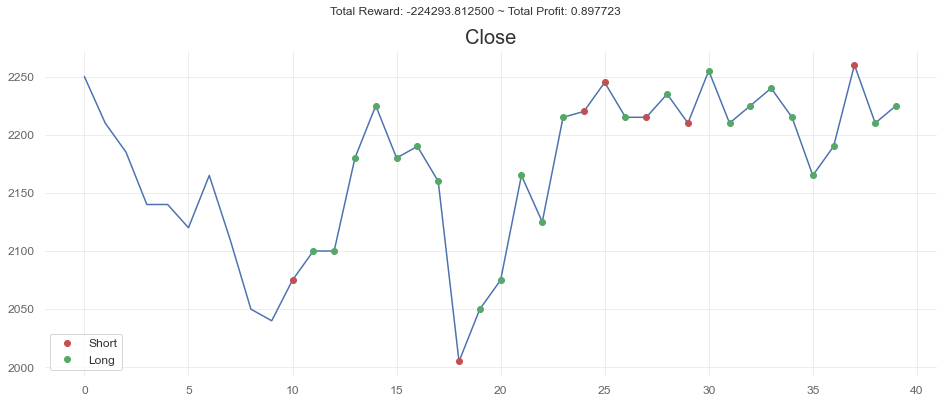

In [30]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 大立光(3008)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


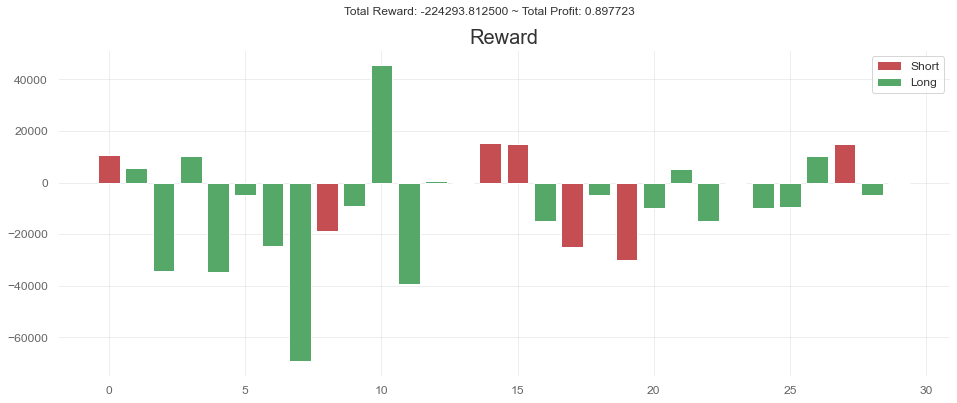

In [31]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易大立光(3008)，所得到的累積利潤(含手續費) ↓↓↓


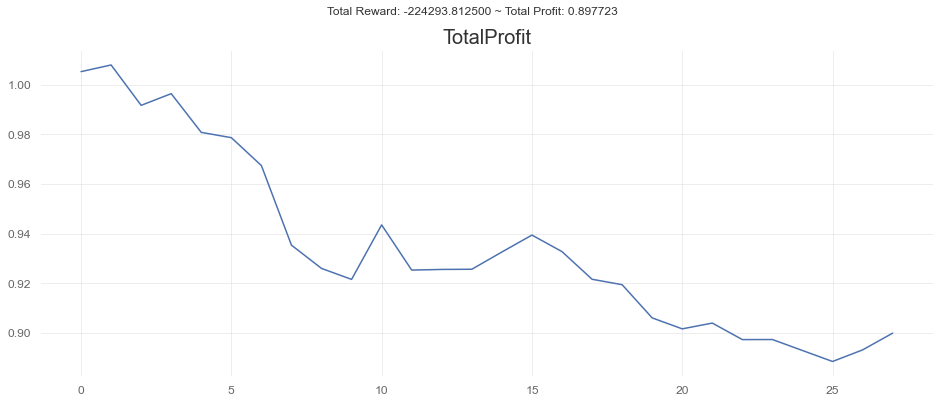

In [32]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [2]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)